<a href="https://colab.research.google.com/github/RohanMathur17/SqueezeNet-Implementation/blob/main/SqueezeNet_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.13.1

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
     |████████████████████████████████| 345.0 MB 4.3 kB/s 
     |████████████████████████████████| 367 kB 49.0 MB/s 
     |████████████████████████████████| 3.2 MB 36.7 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import ReLU
from sklearn.model_selection import train_test_split

datasets = tf.contrib.keras.datasets
layers =  tf.contrib.keras.layers
models = tf.contrib.keras.models
losses = tf.contrib.keras.losses
optimizers = tf.contrib.keras.optimizers 
metrics = tf.contrib.keras.metrics
preprocessing_image = tf.contrib.keras.preprocessing.image
utils = tf.contrib.keras.utils
callbacks = tf.contrib.keras.callbacks


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
## Model Architecture of SqueezeNet
#import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, ReLU
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.layers import concatenate

# Fire Module
def fire_module(x,s1,e1,e3):

    #x --> layer
    #s1 --> squeeze dimension
    #e1 --> expanding for 1x1 layer
    #e3 --> expanding for 3x3 layers

    # Squeezing Layer
    s1x = Conv2D(s1,kernel_size = 1, padding='same')(x)
    s1x = ReLU()(s1x)

    #1x1 expand Layer
    e1x = Conv2D(e1,kernel_size = 1, padding='same')(s1x)

    #3x3 expand Layer
    e3x = Conv2D(e3,kernel_size = 3, padding='same')(s1x)

    #Combining and Passing through ReLU Layer
    x = concatenate([e1x,e3x])
    x = ReLU()(x)

    return x

'''
SqueezeNet begins with a standalone convolution layer (conv1), 
followed by 8 Fire modules (fire1–8), ending with a final conv layer (conv10).
The number of filters per fire module is gradually increased from the beginning to the end of the network.
Max-pooling with a stride of 2 is performed after layers conv1, fire4, fire8, and conv10.
Dropout with ratio of 50% is applied after the fire9 module.

'''
# SqueezeNet Layer
def SqueezeNet(input_shape, nclasses):

    input = Input(input_shape)

    # 1st Convolution
    x = Conv2D(96,kernel_size = (7,7), 
                strides = (2,2),padding='same',input_shape = input_shape)(input)

    # 1st MaxPooling
    x = MaxPool2D((3,3),strides = (2,2),padding='same')(x)

    # FireModule1
    x = fire_module(x,s1 =16,e1=64,e3 = 64)

    # FireModule2
    x = fire_module(x,s1 =16,e1=64,e3 = 64)

    # FireModule3
    x = fire_module(x,s1=32,e1=128,e3=128)

    # 2nd MaxPooling
    x = MaxPool2D((3,3),strides = (2,2),padding='same')(x)

    # FireModule4
    x = fire_module(x,s1 = 32,e1=128,e3=128)

    # FireModule5
    x = fire_module(x,s1 =48,e1=192,e3 =192)

    # FireModule6
    x = fire_module(x,s1 =48,e1=192,e3 =192)

    # FireModule7
    x = fire_module(x,s1 =64,e1=256,e3 =256)
        
    # 3rd MaxPooling
    x = MaxPool2D((3,3),strides = (2,2),padding='same')(x)

    # FireModule8
    x = fire_module(x,s1=64,e1=256,e3=256)

    # 2nd Convolution
    x = Dropout(0.5)(x)
    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Activation('softmax', name='loss')(x)
    model = models.Model(input, out, name='squeezenet')
    return model


In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import os

import cv2

X = []
y = []
base_dir = '/content/gdrive/MyDrive/SqueezeNet/data/'
for f in sorted(os.listdir(base_dir)):
    if os.path.isdir(base_dir+f):
       # print(f"{f} is a target class")
        for i in sorted(os.listdir(base_dir+f)):
           # print(f"{i} is an input image path")
            X.append(base_dir+f+'/'+i)
            y.append(f)

(trainX, testX, trainY, testY) = train_test_split(X,y,
	test_size=0.25,random_state=42)

trainX_list = []
for imagePath in trainX:
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    trainX_list.append(image)

testX_list = []
for imagePath in testX:
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    testX_list.append(image)

trainY_array = np.unique(trainY, return_inverse=True)[1]
trainY_array = trainY_array.reshape(len(trainY_array),1)

testY_array = np.unique(testY, return_inverse=True)[1]
testY_array = testY_array.reshape(len(testY_array),1)

trainX_list_array = np.asarray(trainX_list)
testX_list_array  = np.asarray(testX_list)

#(x_train, y_train), (x_test, y_test)= datasets.cifar10.load_data()

train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)


trainY_array = utils.to_categorical(trainY_array, num_classes=5)
testY_array = utils.to_categorical(testY_array, num_classes=5)

train_generator = train_datagen.flow(x=trainX_list_array, y=trainY_array, batch_size=32, shuffle=True)

test_generator = test_datagen.flow(x=testX_list_array, y=testY_array, batch_size=32, shuffle=True)

In [7]:
def compile_model(model):

    # loss
    loss = losses.categorical_crossentropy

    # optimizer
    optimizer = optimizers.RMSprop(lr=0.0001)

    # metrics
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]

    # compile model with loss, optimizer, and evaluation metrics
    model.compile(optimizer, loss, metric)

    return model

In [8]:
input_shape = (224,224,3)
classes = 5
sn = SqueezeNet(input_shape = input_shape,
					  nclasses = classes)
sn = compile_model(sn)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
history = sn.fit_generator(
    train_generator,
    steps_per_epoch=400,
    epochs=10,
    validation_data=test_generator,
    validation_steps=200)

Epoch 1/10
4/4 [==============================] - 2s 487ms/step - loss: 1.6094 - categorical_accuracy: 0.2393 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.6091 - val_categorical_accuracy: 0.2308 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 2s 399ms/step - loss: 1.6094 - categorical_accuracy: 0.2393 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.6090 - val_categorical_accuracy: 0.2308 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 2s 395ms/step - loss: 1.6090 - categorical_accuracy: 0.2393 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.6085 - val_categorical_accuracy: 0.2308 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 2s 401ms/step - loss: 1.6087 - categorical_accuracy: 0.2393 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.6069 - val_categorical_accuracy: 0.2308 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/10
4/4 [================

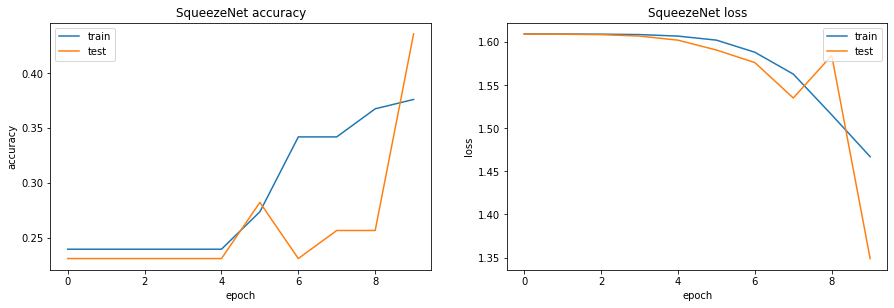

In [11]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()
    
plot_accuracy_and_loss(history)